# Demo Use of SPE

### Imports and Helper Functions

In [1]:
import numpy as np
import torch
from systems import VanDerPol, PhaseSpace, Repressilator
from NFDiffeo import Diffeo
from Hutils import get_oscillator, cycle_error
from fit_SPE import fit_prototype
from matplotlib import pyplot as plt

plt.rcParams.update({
    'font.family': 'sans-serif',
    'figure.dpi': 90,
    'figure.autolayout': True,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'font.size': 18,
    'axes.linewidth': 1.5,
    'lines.linewidth': 3,
    'legend.handlelength': 2.,
    'legend.handletextpad': .4,
    'legend.labelspacing': .0,
    'legend.borderpad': .4,
    'legend.fontsize': 16,
})

In [2]:
def plot_invariant(H, a):
    """
    Plots the limit cycle of radius sqrt(a), through the diffeomorphism H
    """
    if a > 0:
        angles = torch.linspace(0, 2*np.pi, 200)

        true_rad = np.sqrt(a)
        true_pts = torch.stack([
            true_rad*torch.cos(angles),
            true_rad*torch.sin(angles),
        ]).T
        cycle = H.reverse(true_pts).detach().numpy()
        plt.plot(cycle[:, 0], cycle[:, 1], lw=3, color='red', alpha=.7, label='predicted')
    else:
        center = H.reverse(torch.zeros(1, 2)).detach().numpy()[0]
        plt.scatter(center[0], center[1], 90, 'red', alpha=.7, label='pred. cycle', marker='X')

def plot_trajectories(system: PhaseSpace, inits: torch.Tensor, T=30.):
    """
    Plot ground-truth trajectories from a system
    """
    traj = system.trajectories(inits, T=T, step=1e-3, euler=True).numpy()

    for i in range(traj.shape[1]):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=3, color='k', alpha=.8, label='true trajectory' if i==0 else '')


# Limit Cycle Estimation
## Van der Pol System

100%|██████████| 2500/2500 [00:38<00:00, 64.51it/s, loss=0.0088]


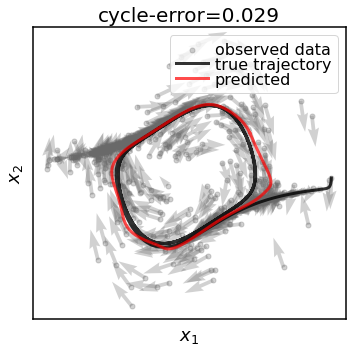

In [3]:
# hyperparameter settings
n_points = 500
its = 2500
lr = 1e-3
center_reg = .0
det_reg = .001
a, omega = .25, -.5
np.random.seed(0)
torch.manual_seed(0)

# load a Van der Pol system with a random limit cycle
system = VanDerPol(**VanDerPol.random_cycle_params())

# sample points from random trajectories of the system
x = system.rand_on_traj(system.random_x(n_points), T=3)
# calculate velocities
xdot = system(0, x)

# fit a diffeomorphism to the given data
H, loss, ldet, score = fit_prototype(
    H=Diffeo(dim=2, n_layers=4, K=4),
    x=x,
    xdot=xdot,
    g=get_oscillator(a=a, omega=omega),
    its=its,
    lr=lr,
    center_reg=center_reg,
    det_reg=det_reg,
    verbose=True,
    weight_decay=1e-3
)

# extract the ground truth cycle by simulating a long path and taking only the second half
cycle_traj = system.trajectories(x[:1], T=50)
cycle_traj = cycle_traj[cycle_traj.shape[0]//2:][:, 0]

# calculate the cycle error
err = cycle_error(H, cycle_traj, a)

plt.figure(figsize=(5, 5))

# plot vectors
norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
dy = .5*xdot/norms
x, dy = x.detach().numpy(), dy.detach().numpy()
std = np.max(x)-np.min(x)
plt.scatter(x[:, 0], x[:, 1], 25, 'dimgray', alpha=.3, label='observed data')
plt.quiver(x[:, 0], x[:, 1], dy[:, 0], dy[:, 1], scale=5, color='dimgray', alpha=.3, width=.012)

# plot trajectories
ind = np.argmax(np.abs(x[:, 0]))
plot_trajectories(system, torch.from_numpy(x[ind:ind+1]), T=30)
plot_invariant(H, a)

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper right')
plt.title(f"cycle-error={err:.3f}")
plt.tight_layout()
plt.show()

## 6D Repressilator System

In [4]:
def repr_invariant(H, a):
    """
    Plots the limit cycle of radius sqrt(a), through the diffeomorphism H
    """
    if a > 0:
        angles = torch.linspace(0, 2*np.pi, 200)

        true_rad = np.sqrt(a)
        true_pts = torch.stack([
            true_rad*torch.cos(angles),
            true_rad*torch.sin(angles),
        ]).T
        true_pts = torch.cat([true_pts, torch.zeros(true_pts.shape[0], 4)], dim=1)
        cycle = H.reverse(true_pts).detach().numpy()
        plt.plot(cycle[:, 1], cycle[:, 3], lw=3, color='red', alpha=.7, label='predicted')
    else:
        center = H.reverse(torch.zeros(1, 6)).detach().numpy()[0]
        plt.scatter(center[1], center[3], 90, 'red', alpha=.7, label='pred. cycle', marker='X')

# set seed and some hyperparameters
torch.manual_seed(0)
np.random.seed(0)

its = 2000
lr = 1e-3
n_points = 500
proj_reg = -1
min_time = 3
T = 10

# simulate noisy vectors from a repressilator system with a limit cycle
system = Repressilator(**Repressilator.random_cycle_params())
x = system.rand_on_traj(system.random_x(n_points, 6), T=T, min_time=min_time)
xdot = system(0, x) + .5*torch.randn_like(x)

# define high dimensional limit cycle prototype
a = .25  # the radius of the limit cycle in the prototype
omega = 1.5  # angular velocity in the prototype
decay = .5  # decay factor towards the first two dimensions
archetype = get_oscillator(a=a, omega=omega, decay=decay)

# fit a diffeomorphism to the data with the prototype defined above
H, _, _, score = fit_prototype(
    H=Diffeo(dim=6, n_layers=4, K=5),
    x=x,
    xdot=xdot,
    g=archetype,
    its=its,
    lr=lr,
    center_reg=.0,
    det_reg=.001,
    verbose=True,
    weight_decay=1e-3,
    proj_reg=proj_reg,
    noise=.1
)

print(f'score={score:.4f}')  # print the fitting score - the loss only calculated on the first 2 dimensions of the prototype

100%|██████████| 2000/2000 [01:25<00:00, 23.52it/s, loss=0.0281; projvar=0.358]

score=0.0191


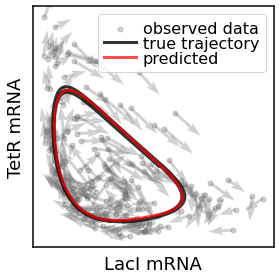

In [5]:
plt.figure(figsize=(4, 4))

# plot vectors
norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
dy = xdot/norms  # normalizes vectors so visualization is cleaner
y, dy = x.detach().numpy(), dy.detach().numpy()

M = 200  # plot only M vectors, to keep visuals cleaner
plt.scatter(y[:M, 0], y[:M, 2], 25, 'dimgray', alpha=.3, label='observed data')
plt.quiver(y[:M, 0], y[:M, 2], dy[:M, 0], dy[:M, 2], scale=5, color='dimgray', alpha=.3, width=.012)

# plot a random, long, trajectory from the hidden system, as reference
ind = np.argmax(np.abs(y[:, 0]))
inits = torch.from_numpy(y).float()[ind:ind+1]
traj = system.trajectories(inits, T=30, step=1e-3, euler=True).numpy()
traj = traj[len(traj)//2:]  # keep only second half of trajectory, so all points are in the vicinity of the limit cycle
plt.plot(traj[:, 0, 0], traj[:, 0, 2], lw=3, color='k', alpha=.8, label='true trajectory')

repr_invariant(H, a)  # plot estimated limit cylce on a 2D projection

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel('LacI mRNA')
plt.ylabel('TetR mRNA')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# estimate points on the limit cycle using the diffeomorphism (2 cycles)
angles = torch.linspace(0, 4*np.pi, 600)
true_rad = np.sqrt(a)
true_pts = torch.stack([
    true_rad*torch.cos(angles),
    true_rad*torch.sin(angles),
]).T
true_pts = torch.cat([true_pts, torch.zeros(true_pts.shape[0], 4)], dim=1)
cycle = H.reverse(true_pts).detach().numpy()

# simulate ground truth system for a long trajectory from the above limit cycle
inits = torch.from_numpy(cycle[0:1]).float()
T = 30
t = np.arange(0, T, 1e-3)
traj = system.trajectories(inits, T=31, step=1e-3).numpy()[:, 0]
traj = traj[traj.shape[0]//2:]
t = t[len(t)//2:]

# align the trajectory from the hidden system with the one found
inits = inits.numpy()
dists = np.mean((traj - inits)**2, axis=1)
ddists = dists[1:] - dists[:-1]

inds = []
for i in range(1, len(ddists)-1):
    if ddists[i-1] < 0 < ddists[i]: inds.append(i)
    if len(inds) == 3: break

traj = traj[inds[0]:inds[-1]]
t = t[inds[0]:inds[-1]]
t = t-np.min(t)

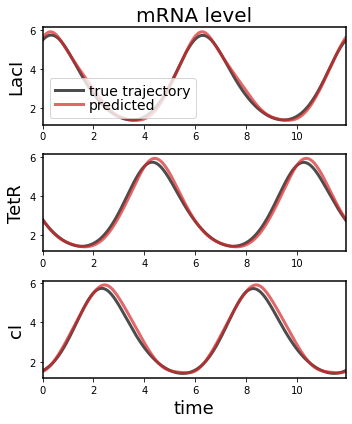

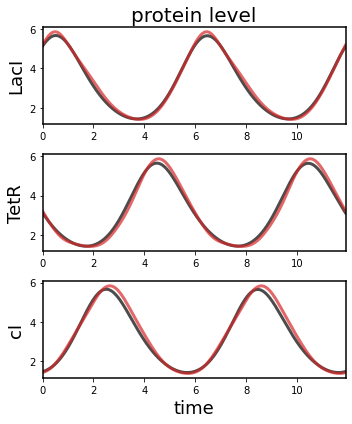

In [7]:
cycle_time = np.linspace(0, t[-1], cycle.shape[0])  # define time through points on the cycle

# ===================== plot mRNA
plt.figure(figsize=(5, 6))
for i, (ind, name) in enumerate(zip([0, 2, 4], ['LacI', 'TetR', 'cI'])):
    plt.subplot(3, 1, i+1)
    line = traj[:, ind]
    plt.plot(t, line, lw=3, color='k', alpha=.7, label='true trajectory')
    line = cycle[:, ind]
    plt.plot(cycle_time, line, lw=3, color='tab:red', alpha=.7, label='predicted')
    plt.ylabel(name)
    plt.xlim(t[0], t[-1])
    if ind==4: plt.xlabel('time')
    if i==0:
        plt.legend(loc='lower left', fontsize=14)
        plt.title('mRNA level')
plt.tight_layout()
plt.show()

# ===================== plot protein
plt.figure(figsize=(5, 6))
for i, (ind, name) in enumerate(zip([0, 2, 4], ['LacI', 'TetR', 'cI'])):
    plt.subplot(3, 1, i+1)
    line = traj[:, ind+1]
    plt.plot(t, line, lw=3, color='k', alpha=.7, label='ground truth')
    line = cycle[:, ind+1]
    plt.plot(cycle_time, line, lw=3, color='tab:red', alpha=.7, label='predicted')
    plt.ylabel(name)
    plt.xlim(t[0], t[-1])
    if ind==4: plt.xlabel('time')
    if i==0: plt.title('protein level')
plt.tight_layout()
plt.show()